# Investment and Trading Capstone Project

## Build a Stock Price Indicator

### project overview

Investment firms, hedge funds and even individuals have been using financial models to better understand market behavior and make profitable investments and trades. A wealth of information is available in the form of historical stock prices and company performance data, suitable for machine learning algorithms to process. 

This project uses this historical stock prices from finnhub.io to make predictions on the development of these stocks. The result of this process will implememnted in a website giving the user the possibility to choose a certain timeframe or stock to analyze.

### problem statement

The problem to be tackled in this project is to predict future adjsuted stock closing prices for certain stocks. To do so we will make use of several regression and deep learning models to achieve a maximum of accuracy for our predictions. 
The user interaction of this project will be implemented in a website/dashboard. There it will be possible to choose the stock of interest and a certain timeframe to predict data for the fututre.

## Exploratory Data Analysis

In this part we will have a closer look at the underlying data to decide how exactly we will deal with it in order to achieve the above mentioned results. Let's read in some libraries and the data first.

In [1]:
import sys
print(sys.path)
print(sys.executable)

['c:\\Users\\yvesd\\Udacity\\Data Scientist\\stock_forecast', 'c:\\Users\\yvesd\\.vscode\\extensions\\ms-python.python-2020.8.103604\\pythonFiles\\vscode_datascience_helpers\\..\\.does-not-exist', 'c:\\Users\\yvesd\\.vscode\\extensions\\ms-python.python-2020.8.103604\\pythonFiles', 'c:\\Users\\yvesd\\.vscode\\extensions\\ms-python.python-2020.8.103604\\pythonFiles\\lib\\python', 'C:\\Users\\yvesd\\miniconda3\\envs\\stocks\\python38.zip', 'C:\\Users\\yvesd\\miniconda3\\envs\\stocks\\DLLs', 'C:\\Users\\yvesd\\miniconda3\\envs\\stocks\\lib', 'C:\\Users\\yvesd\\miniconda3\\envs\\stocks', '', 'C:\\Users\\yvesd\\miniconda3\\envs\\stocks\\lib\\site-packages', 'C:\\Users\\yvesd\\miniconda3\\envs\\stocks\\lib\\site-packages\\win32', 'C:\\Users\\yvesd\\miniconda3\\envs\\stocks\\lib\\site-packages\\win32\\lib', 'C:\\Users\\yvesd\\miniconda3\\envs\\stocks\\lib\\site-packages\\Pythonwin', 'C:\\Users\\yvesd\\miniconda3\\envs\\stocks\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\yvesd\\.ipyt

In [66]:
import warnings
import itertools
import pandas as pd
import numpy as np
import requests
import finnhub
from datetime import datetime
from functools import reduce
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from forecasting_metrics import mape, mase

warnings.filterwarnings('ignore')

### data

We obtain our data from an API at www.finnhub.io. We're especially interested in the candlestick data for stocks going back 25 years for US stocks. As an example in this notebook we choose to work the the Google stock (GOOG).

In [67]:
# Setup client
finnhub_client = finnhub.Client(api_key="bsrr9nn48v6u62sfl8cg")

In [71]:
def convert_to_unix(timestamp):
    """Converts a pandas timestamp to a unix integer."""
    return (timestamp - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

def convert_to_timestamp(unix):
    """Converts a unix integer into a pandas datetime object."""
    return pd.to_datetime(unix, unit='s')

In [5]:
def forecast_accuracy(actual, forecast):
    """
    Calculate the Symmetric mean absolute percentage error.
    Arguments:
    actual - actual values to compare the predictions to
    forecast - predicted values to evaluate
    Returns:
    smape - percentage of symmetric mean absolute percentage error
    """
    # convert series to value arrays
    actual = actual.values
    forecast = forecast.values

    return mape(actual, forecast), mase(actual, forecast)

In [96]:
def get_ohlc_data(symbols, timedelta='5y'):
    """
    Queries list of stock symbols for their OHLC data.
    Arguments:
    symbols - list of strings containing the stock symbol of the desired stock
    Returns:
    ohlc_data - dict of dataframes containing ohlc data for each symbol over certain timeframe
    """
    ohlc_data = dict()
    # get start & endtime for ohlc data
    start_time = convert_to_unix(datetime.now() - pd.Timedelta(timedelta))
    end_time = convert_to_unix(datetime.now())
    # set resolution for query to 'Daily'
    resolution = 'D'
        
    # get OHLC data for each symbol
    for symbol in symbols:
        # try:
        res = finnhub_client.stock_candles(symbol, resolution, start_time, end_time)
        # r = requests.get(
        #     'https://finnhub.io/api/v1/stock/candle?symbol={}&resolution=D&from={}&to={}&adjusted=true'.format(
        #     symbol, from_time, to_time))

        data = pd.DataFrame(res)
        data = data.set_index(convert_to_timestamp(data.t))

        # data = pd.DataFrame(
        #     index= [convert_unix_to_timestamp(x).date() for x in r.json()['t']],
        #     data = {'open': r.json()['o'],
        #             'high': r.json()['h'],
        #             'low': r.json()['l'],
        #             'adj_close': r.json()['c'],
        #             'volume': r.json()['v']})
        ohlc_data.update({symbol: data})
    
    return ohlc_data

In [99]:
symbols = ['GOOG', 'AAPL', 'AMZN', 'MSFT']
ohlc_data = get_ohlc_data(symbols)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2015-08-27 to 2020-08-25
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   c       1258 non-null   float64
 1   h       1258 non-null   float64
 2   l       1258 non-null   float64
 3   o       1258 non-null   float64
 4   s       1258 non-null   object 
 5   t       1258 non-null   int64  
 6   v       1258 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 78.6+ KB


In [10]:
def transform_data(df, column):
    """
    Transforms data in normal distributed series via SQRT or BoxCox transformation and plots results.
    
    Arguments:
    df - dataframe containing data to transform
    column - string with name of the column to transform
    type - 'SQRT' for Squareroot Transformation OR 'BoxCox' for BoxCox Transformation
    Returns:
    transformed_data - sqrt transformed data series
    """
    df['sqrt_trans'] = np.sqrt(df[column])
    
    # creating axes to draw plots 
    fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
    # plotting original data and transformed data
    ax[0].hist(df[column], color ="blue")
    ax[0].set_title('Original')
    ax[1].hist(df['sqrt_trans'], color ="blue") 
    ax[1].set_title('SQRT-Transform')
    
    return df

In [11]:
def split_data(timeseries, len_forecast=30):
    """
    Split timeseries into test and train dataset.
    Arguments:
    timeseries - timeseries to be split
    len_forecast - number of days to predict
    Returns:
    train_data - timeseries of train data values
    test_data - timeseries of train data values
    """
    train_data = timeseries[:-len_forecast]
    test_data = timeseries[-len_forecast:]
    
    return train_data, test_data

In [102]:
def prepare_data(symbol):
    """
    Load dataset for a specified symbol from the dictionary.
    Tranform and split the data in train and test set.
    Arguments:
    symbol - symbol from existing dataset in ohlc_data dictionary
    Returns:
    y_train - SQRT transformed train dataset
    y_test - SQRT transformed test dataset
    df - original dataframe with transformed data
    """
    
    # load dataframe from dictionary
    df = ohlc_data[symbol]
    print(df.info())

    # transfomr and split data
    df = transform_data(df, 'c')
    y_train, y_test = split_data(df.sqrt_trans)

    return y_train, y_test, df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2015-08-27 to 2020-08-25
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   c           1258 non-null   float64
 1   h           1258 non-null   float64
 2   l           1258 non-null   float64
 3   o           1258 non-null   float64
 4   s           1258 non-null   object 
 5   t           1258 non-null   int64  
 6   v           1258 non-null   int64  
 7   sqrt_trans  1258 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 88.5+ KB
None


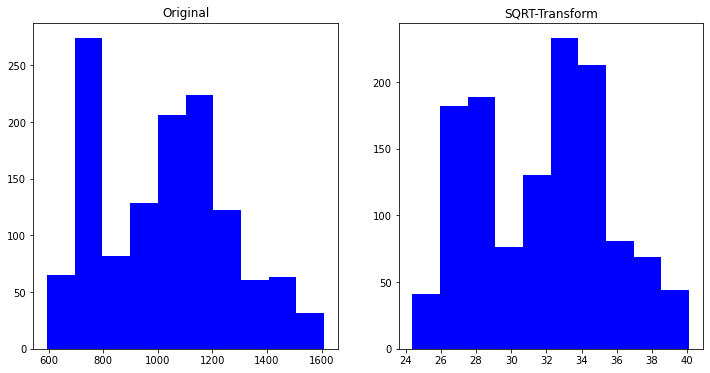

In [103]:
y_train, y_test, df = prepare_data('GOOG')

We can see that we got back a complete dataset without any null values. There is no further cleaning required. The performed transformation improves our data towards a normal distribution that is generally preferred for machine learning algorithms. 

In [106]:
def plot_ohlc(symbol):
    """
    Plots the ohlc data for a given symbol and timeframe.
    Arguments:
    symbols - list of strings representing the name of a stock symbol that is contained in the ohlc dictionary.
    Returns:
    None
    """
    
    df = ohlc_data[symbol]
    
    fig = go.Figure(data=[
        go.Candlestick(
            name=symbol,
            x=df.index,
            open=df.o,
            high=df.h,
            low=df.l,
            close=df.c)])

    fig.update_layout(
        xaxis_rangeslider_visible=False,
        title='OHLC Stock Chart for: {}'.format(symbol))
    fig.show()

In [107]:
plot_ohlc('GOOG')

Above we mentioned that there are no missing values in our datasets. However, zooming in we can observe gaps in both of the graphs above. This is due to the fact that the stock markets are closed on weekends and certain holidays. This shouldn't be a problem for our prediction as we want to predict for predefined steps in the future like 7 or 30 days. So we're predicting for a certain amount of business days in the future and the actual date doesn't really matter.

## Algorithm Evaluation

In this chapter we will have a look on different models to predict stock prices and evaluate their performance to decide which algorithm to implement in the final stock price predictor. But first let's take a look on our data with a so called LAG plot. The patterns in a LAG plot can help to identify correlations in the data.

In [13]:
def plot_autocorrelation(y):
    """Plots the AutoCorrlation for a lag to 6."""

    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    axes = axes.flatten()
    
    for i in range(len(axes)):
        pd.plotting.lag_plot(y, lag=i+1, ax=axes[i])
        axes[i].set_title('LAG = {}'.format(i+1))

    plt.show()

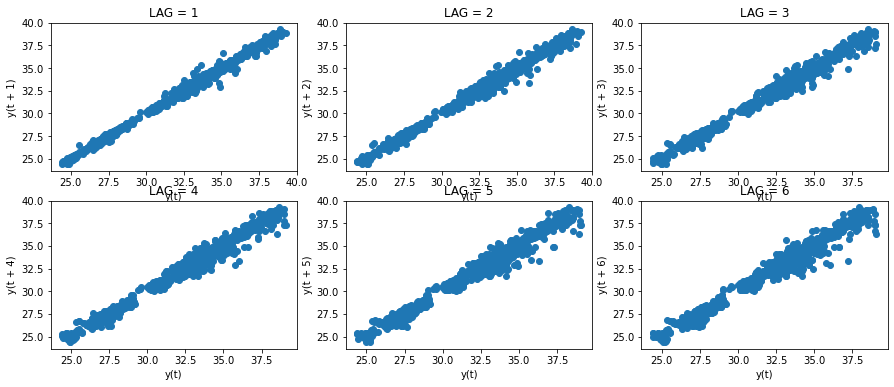

In [14]:
plot_autocorrelation(y_train)

All of the above lag graphs look fairly linear. This is a good indicator that an auto-regressive model is a good choice. We want to have a look on the ARIMA model in particular.

### AutoRegressive model (AR):
AR models operate under the assumption that previous values have an impact on current values. As long as the assumptions holds we're able to predict a value of a dependent variable today, given the values it had in the past. The order of the AR model corresponds to the number of previous values taken into account.

### Moving Average Model (MA)
The MA model assumes that the current value of the dependent variable is related to the previous days error terms. The number of previous errors to be considered is called the order of the MA model. E.g. if we assume an order of 3, we would consider *e(t-3), e(t-2) and e(t-1)* as inputs for our regressor with *e(i) = moving_average(i) - actual_value(i)*

### Auto Regressive Moving Average (ARMA):
Is the combination of the above two models.

### ARIMA model

ARIMA stands for *AutoRegressor Integrated Moving Average* and is a regression model. It adds differencing to the ARMA model and can be used to transform a timeseries into a stationary series. First order differencing smoothes linear trends in the data by the transformation $$ z_i = y_i - y_{i-1}$$ whereas second order differencing adreses quadratic trends and so on.

The features are desccribed by the parameters p, d and q as follows:

 - p: number of previous values to take into account for the current estimation (AR order)
 - d: number describing the differencing order
 - q: number of previous errors (MA order)
 
To determine the values for p, d and q we will evaluate some statistics of  our timeseries. We'll later validate the results in a sort of GridSearch. We declare a matrix of possible values for each variable and fit a model with these values. We'll then compare the scores of every fitting with each other and choose the parameter set with the overall best score. 

Most of the models dealing with TimeSeries data work on the assumption that the data is stationary. Stationary means that it's statistical properties such as mean or standard deviation remain constant over time. We can assume the series to be stationary if it has constant statistical properties over time, i.e. the following:

 - constant mean
 - constant variance
 - an autocovariance that doesn't depend on time

To check for stationarity of a timeseires we can take the Dickey-Fuller test. The Null Hypothesis is that the TimeSeries is not stationary. The results of this test are a Test Statistic and some Critical Values for different confidence levels. If the Test Statistic is smaller than the Critical Value we can reject the Null Hypothesis and say the series is stationary.

In [15]:
def check_stationarity(timeseries):
    """Checks the timeseries for stationarity via Dickey-Fuller test."""
    
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

In [16]:
check_stationarity(y_train)

ADF Statistic: -1.011891907456248
p-value: 0.7489023280622595
Critical Values:
	1%: -3.435761408287299
	5%: -2.863929614852828
	10%: -2.568042270495956


We can see that our intial timeseries is not stationary. The ADF statistic is far away from the critical values and the p-value isn't anywhere near our desired alpha of 0.05. This means we have to take measures totranform our timeseries in a stationary state.

A common way to transform a timeseries into a stationary state is differencing. That means that we subtract the previous value from the current one. Eventually we'll be requrired to difference more than once to achieve stationarity. The ideal order of differencing is minimum differencing required to get a near stationary series which roams around a defined mean and the ACF plot reaches to zero quickly. By all means we want to avoid over-differencing here.

In [17]:
def check_autocorrelation(timeseries):
    
    # create axes for original series and for each differencing order
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    # Original Series
    axes[0, 0].plot(timeseries); 
    axes[0, 0].set_title('Original Series')
    plot_acf(timeseries, ax=axes[0, 1])
    
    # 1st Differencing
    axes[1, 0].plot(timeseries.diff()); 
    axes[1, 0].set_title('1st Order Differencing')
    plot_acf(timeseries.diff().dropna(), ax=axes[1, 1])

    # 2nd Differencing
    axes[2, 0].plot(timeseries.diff().diff()); 
    axes[2, 0].set_title('2nd Order Differencing')
    plot_acf(timeseries.diff().diff().dropna(), ax=axes[2, 1])

    plt.show()

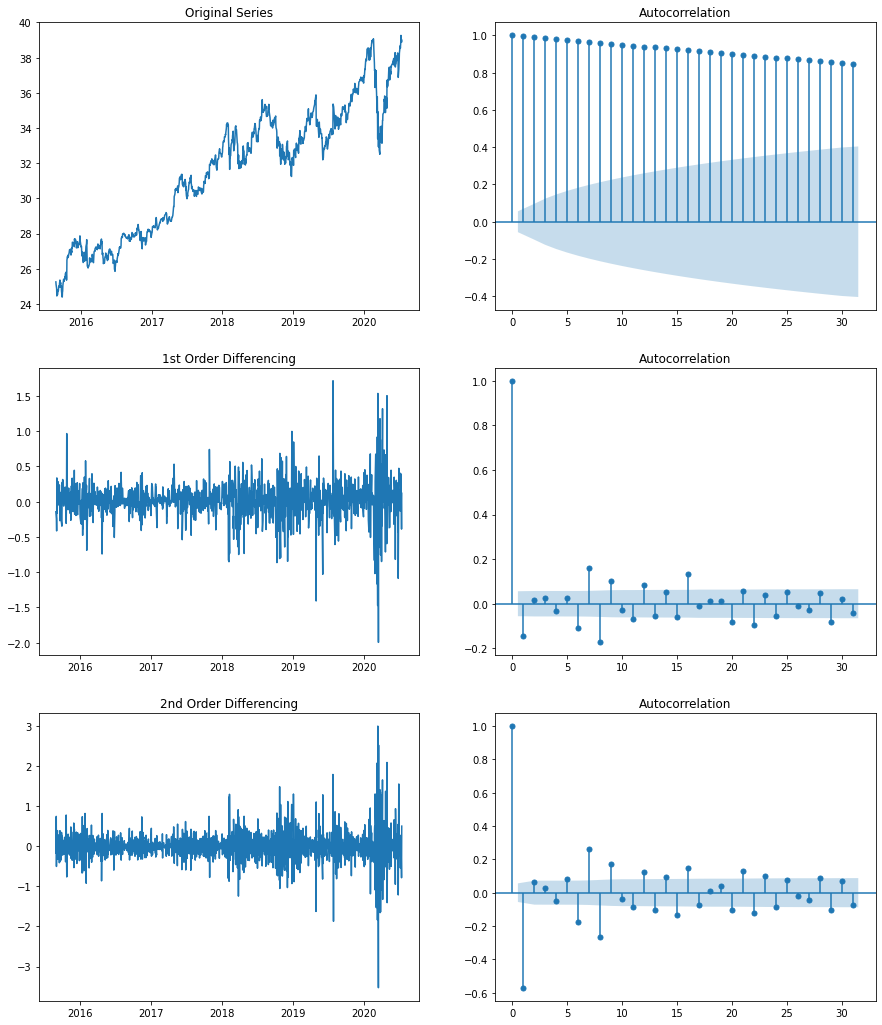

In [18]:
check_autocorrelation(y_train)

Even though the series seems stationary with the first differencing, the ACF plot instantly goes into the negative scale. This bears the danger of over-differencing. But since the series is not stationary without differencing we will have to stick to the first order differencing.

In [19]:
check_stationarity(y_train.diff().dropna())

ADF Statistic: -8.132119340837626
p-value: 1.0832148245021976e-12
Critical Values:
	1%: -3.435761408287299
	5%: -2.863929614852828
	10%: -2.568042270495956


The Dickey Fuller test confirms that the series is now stationary after differncing once so we can log in our parameter with **d = 1**.

The next parameter would be the AR-order (p).

In [20]:
def check_pacf(timeseries):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    axes[0].plot(timeseries.diff()); 
    axes[0].set_title('1st Differencing')
    plot_pacf(timeseries.diff().dropna(), ax=axes[1])

    plt.show()

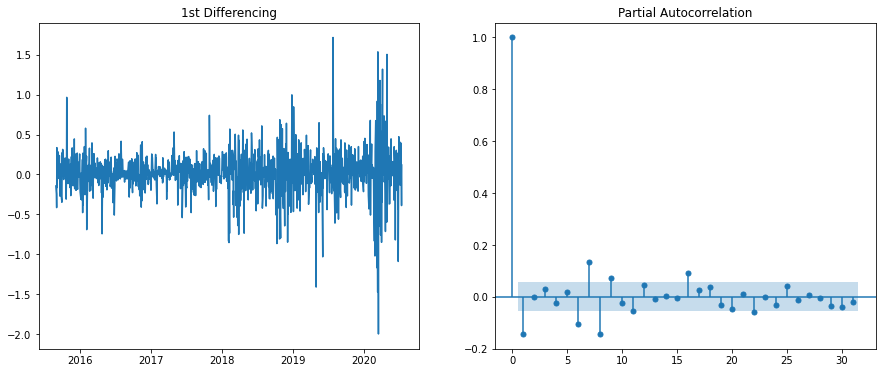

In [21]:
check_pacf(y_train)

We can observe that there are several lags that can be considered significant (outside of the blue box). Usually we would go with the first lag that is considered significant what would be **p = 7** in our case. Here we will confirm our assumption by a GridSearch over a set of parameters to get the best results when fitting our model. Ideally this yields the same result for the AR parameter.

Let's go on with the MA-term of our model (q):

In [22]:
def check_acf(timeseries):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    axes[0].plot(timeseries.diff()); 
    axes[0].set_title('1st Differencing')
    plot_acf(timeseries.diff().dropna(), ax=axes[1])

    plt.show()

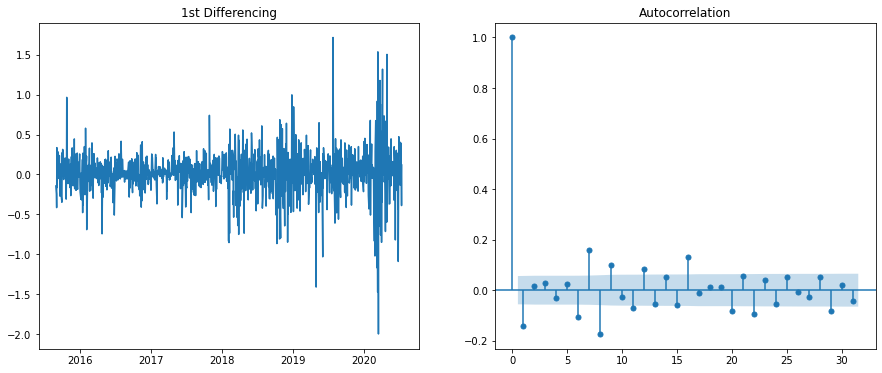

In [23]:
check_acf(y_train)

Again, there are a couple of lags that are well above the confidence interval. We would go with **q = 7** here and crossvalidate the choice later. When in doubt, go with the simpler model that sufficiently explains the Y.

In [24]:
def find_param_set(y_train, min_p, max_p, min_d, max_d, min_q, max_q):
    """
    Finds the optimal parameter set as input for ARIMA model by comparing AIC & BIC scores.
    
    Arguments:
    y_train - timeseries to fit
    max_p - max of p to verify as input for ARIMA model
    max_d - max of d to verify as input for ARIMA model
    max_q - max of q to verify as input for ARIMA model
    Returns:
    param - tuple (p, d, q) of best parameter set
    """
    
    trend = ['c', 't', 'ct']
    # Generate all different combinations of p, q and q triplets
    param_set = list(itertools.product(
        range(min_p, max_p), 
        range(min_d, max_d), 
        range(min_q, max_q), 
        trend))
    
    results_df = pd.DataFrame(columns=['params', 'aic', 'bic'])

    for param in param_set:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train, order=param[:3], trend=param[3], 
                        enforce_stationarity=False,
                        enforce_invertibility=False)

            results = mod.fit()

            results_df = results_df.append({
                'params': param, 
                'aic': results.aic,
                'bic': results.bic}, 
                ignore_index=True)
        except:
            continue
    
    results_df = results_df.sort_values(['aic', 'bic'])
    
    print("The best parameter set for the ARIMA model is: {} with an AIC of: {} and BIC of: {}."
          .format(results_df.iloc[0].params, results_df.iloc[0].aic, results_df.iloc[0].bic))

    return results_df.iloc[0].params

In [25]:
p, d, q, trend = find_param_set(y_train, 6, 10, 1, 2, 6, 10)

The best parameter set for the ARIMA model is: (8, 1, 8, 'c') with an AIC of: 179.72737026070456 and BIC of: 271.61674832956174.


In [26]:
model = sm.tsa.statespace.SARIMAX(y_train, order=(p, d, q), trend=trend, 
                        enforce_stationarity=False,
                        enforce_invertibility=False)
fitted_model = model.fit()

In [27]:
fitted_model.save('./models/arima.pkl')

In [374]:
fitted_model.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
intercept,0.0249,0.016,1.548,0.122,-0.007,0.056
ar.L1,-0.1332,0.071,-1.878,0.060,-0.272,0.006
ar.L2,-0.0181,0.061,-0.298,0.766,-0.137,0.101
ar.L3,-0.0208,0.061,-0.344,0.731,-0.140,0.098
ar.L4,-0.1258,0.055,-2.306,0.021,-0.233,-0.019
ar.L5,0.1828,0.053,3.461,0.001,0.079,0.286
ar.L6,-0.0909,0.062,-1.456,0.145,-0.213,0.031
ar.L7,-0.2921,0.055,-5.320,0.000,-0.400,-0.185
ar.L8,-0.7100,0.057,-12.484,0.000,-0.821,-0.599
ma.L1,-0.0479,0.082,-0.583,0.560,-0.209,0.113


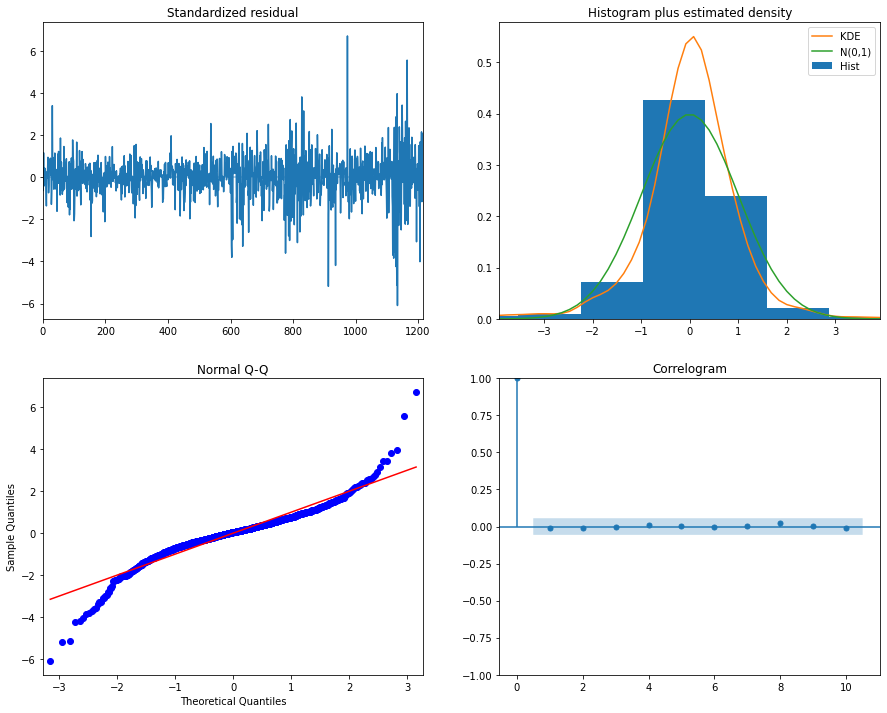

In [28]:
fitted_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Our goal here is to make sure that the residuals of our model are normally distributed around a mean of 0 aswell as uncorrelated. 

 - The upper left plot tells us that our residuals don't show any obvious patterns in term of seasonality and are in fact so called white noise. This is confirmed by the plot in on the lower right. The Correlogram shows that the residuals have a low correlation to lagged versions of itself.
 - The upper roght plot shows the Kernel density estimation (KDE) of our residuals in comparison to a normal distributed variable with mean=0 and standard deviation=1. The plot tells us that our residuals have less values on the outer edges but more in the center around 0 compared to a standard normal distribution. 
  - The above fact is further confirmed by the QQ- plot in the lower left. The ordered distribution of residuals (blue dots) should follow the linear trend of samples taken from a standard normal distribution with N(0,1). Again, this is a sign that our residuals aren't distributed ideally normal.

In [37]:
def predict_prices(len_forecast, y_train=y_train, y_test=y_test, dynamic_forecast=False):
    """Predict values for the next X business days and plots results.
    Arguments:
    len_forecast - integer with number of days to predict
    Returns:
    None
    """

    pred = fitted_model.get_prediction(
        start=y_train.size + 1, 
        end=y_train.size + len_forecast, 
        dynamic=dynamic_forecast)
    pred_ci = pred.conf_int()

    evaluate_prediction(y_train, y_test, pred, pred_ci, len_forecast)   

In [34]:
def evaluate_prediction(y_train, y_test, pred, pred_ci, len_forecast):
    """
    Plot predicted values vs actual test data.

    Arguments:
    pred - model object with predicted values
    pred_ci - dataframe with data for confidence interval
    len_forecast - integer with number of days to predict
    Returns:
    None
    """
    # transform values back to original scale
    y_train = y_train[-len_forecast:]**2
    y_test = y_test[:len_forecast]**2
    preds = pred.predicted_mean**2
    lower_conf_int = pred_ci[pred_ci.columns[0]]**2
    upper_conf_int = pred_ci[pred_ci.columns[1]]**2

    # calculate evaluation metrics
    mape_score = mape(y_test.values, preds.values) * 100
    mase_score = mase(y_test.values, preds.values) * 100
    
    # plot actual vs. predicted values
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    ax.plot(y_train, color='blue', label='Training Data')
    ax.plot(y_test.index, preds, color='green', marker='o', label='Predicted Price')
    ax.plot(y_test.index, y_test, color='red', label='Actual Price')
     # add confidence intervall
    ax.fill_between(y_test.index,
                        lower_conf_int, 
                        upper_conf_int,
                        alpha=0.4, color='grey',
                        label="Confidence Intervals")
    ax.set_title('Prices Prediction for {} days \t - \t MAPE: {:.2f} \t MASE: {:.2f}'.format(len_forecast, mape_score, mase_score))
    ax.set_xlabel('Dates')
    ax.set_ylabel('Prices')
    ax.legend()

    plt.show()

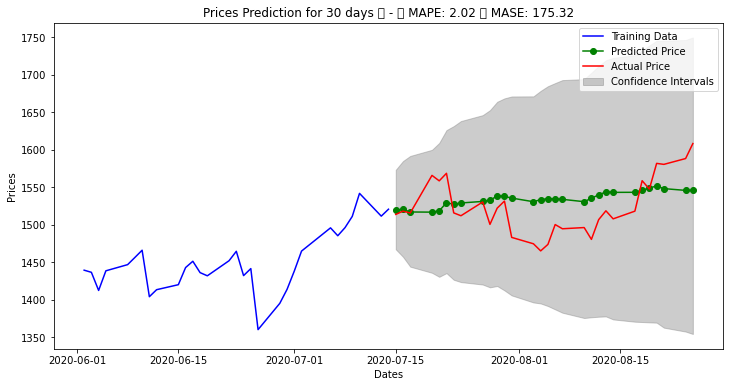

In [38]:
predict_prices(30)

In [32]:
forecasts = [1, 2, 3, 4, 5, 10, 20, 30]
evaluation = pd.DataFrame(columns=['len_forecast', 'mape', 'mase'])
for len_forecast in forecasts:
    forecast = fitted_model.get_prediction(
        start=y_train.shape[0] + 1, 
        end=y_train.shape[0] + y_test[:len_forecast].shape[0], 
        dynamic=False)

    forecast =  forecast.predicted_mean.values ** 2
    actual = y_test[:len_forecast].values ** 2

    mape_score = mape(actual, forecast)
    mase_score = mase(actual, forecast)
    evaluation = evaluation.append({
                'len_forecast': len_forecast, 
                'mape': mape_score * 100,
                'mase': mase_score * 100}, 
                ignore_index=True)

evaluation


,len_forecast,mape,mase
0,1.0,0.397331,NaN
1,2.0,0.274057,95.218465
2,3.0,0.212076,94.355763
3,4.0,0.942152,77.241223
4,5.0,1.267553,122.863776
5,10.0,1.290788,100.098697
6,20.0,2.073428,176.671297
7,30.0,2.024878,175.315983


In [101]:
for symbol in ohlc_data.keys():
    print(symbol)

    df = prepare_data(symbol)

GOOG
AAPL
AMZN
MSFT
